# Getting Started

Bambi requires a working Python interpreter (3.7+). We recommend installing Python and key numerical libraries using the [Anaconda Distribution](https://www.anaconda.com/products/individual), which has one-click installers available on all major platforms.

Assuming a standard Python environment is installed on your machine (including pip), Bambi itself can be installed in one line using pip:

    pip install bambi

Alternatively, if you want the bleeding edge version of the package, you can install from GitHub:

    pip install git+https://github.com/bambinos/bambi.git

## Quickstart

Suppose we have data for a typical within-subjects psychology experiment with 2 experimental conditions. Stimuli are nested within condition, and subjects are crossed with condition. We want to fit a model predicting reaction time (RT) from the common effect of condition, group specific intercepts for subjects, group specific condition slopes for students, and group specific intercepts for stimuli. Using Bambi we can fit this model and summarize its results as follows:

```python
from bambi import Model

# Assume we already have our data loaded as a pandas DataFrame
model = Model("rt ~ condition + (condition|subject) + (1|stimulus)", data)
results = model.fit(draws=5000, chains=2)
az.plot_trace(results)
az.summary(results)
```

## User Guide

### Setup

In [1]:
import arviz as az
import numpy as np
import pandas as pd

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)

### Creating a model

Creating a new model in Bambi is simple:

In [3]:
from bambi import Model

# Read in a tab-delimited file containing our data
data = pd.read_table('data/my_data.txt', sep='\t')

# Initialize the model
model = Model("y ~ x + z", data)

# Inspect model object
model

Formula: y ~ x + z
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(mu: 0.18519853, sigma: 1.03314715)
  x ~ Normal(mu: 0, sigma: 0.78834175)
  z ~ Normal(mu: 0, sigma: 0.85354979)
  sigma ~ HalfStudentT(nu: 4, sigma: 1.01300188)

Typically, we will initialize a Bambi ``Model`` by passing it a model formula and a pandas ``DataFrame``. Other arguments such as family, priors, and link are available. By default, it uses ``family="gaussian"`` which implies a linear regression with normal error. We get back a model that we can immediately fit by calling ``model.fit()``.

### Data format

As with most mixed effect modeling packages, Bambi expects data in "long" format--meaning that each row should reflects a single observation at the most fine-grained level of analysis. For example, given a model where students are nested into classrooms and classrooms are nested into schools, we would want data with the following kind of structure:

|student| gender | gpa    |  class | school
|:-----:|:------:|:------:|:------:| :------:|
1       |F       |3.4     | 1      |1 |
2       |F       |3.7     | 1      |1 |
3       |M       |2.2     | 1      |1 |
4       |F       |3.9     | 2      |1 |
5       |M       |3.6     | 2      |1 |
6       |M       |3.5     | 2      |1 |
7       |F       |2.8     | 3      |2 |
8       |M       |3.9     | 3      |2 |
9       |F       |4.0     | 3      |2 |


## Formula-based specification

Models are specified in Bambi using a formula-based syntax similar to what one might find in R packages like lme4 or brms using the Python [formulae](https://github.com/bambinos/formulae) library. A couple of examples illustrate the breadth of models that can be easily specified in Bambi:

In [4]:
data = pd.read_csv('data/rrr_long.csv')
data.head(10)

,uid,condition,gender,age,study,self_perf,stimulus,value
0,1.0,0.0,1.0,24.0,0.0,8.0,rating_c1,3.0
1,2.0,1.0,0.0,27.0,0.0,9.0,rating_c1,7.0
2,3.0,0.0,1.0,25.0,0.0,3.0,rating_c1,5.0
3,5.0,0.0,1.0,20.0,0.0,3.0,rating_c1,7.0
4,8.0,1.0,1.0,19.0,0.0,6.0,rating_c1,6.0
5,9.0,0.0,1.0,22.0,0.0,3.0,rating_c1,6.0
6,10.0,1.0,1.0,49.0,0.0,4.0,rating_c1,6.0
7,11.0,0.0,0.0,24.0,0.0,5.0,rating_c1,7.0
8,12.0,1.0,0.0,26.0,0.0,6.0,rating_c1,2.0
9,13.0,0.0,1.0,23.0,0.0,7.0,rating_c1,1.0


In [5]:
# Number of rows with missing values
data.isna().any(axis=1).sum()

401

We pass ``dropna=True`` to tell Bambi to drop rows containing missing values. The number of rows dropped is different from the numer of rows with missing values because Bambi only considers columns involved in the model.

In [6]:
# Common (or fixed) effects only
Model("value ~ condition + age + gender", data, dropna=True)

Automatically removing 33/6940 rows from the dataset.


Formula: value ~ condition + age + gender
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Intercept ~ Normal(mu: 4.5456783, sigma: 10.32624097)
  condition ~ Normal(mu: 0, sigma: 4.35989139)
  age ~ Normal(mu: 0, sigma: 0.47056722)
  gender ~ Normal(mu: 0, sigma: 4.75602029)
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41856923)

In [7]:
# Common effects and group specific (or random) intercepts for subject
Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)

Automatically removing 33/6940 rows from the dataset.


Formula: value ~ condition + age + gender + (1|uid)
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Intercept ~ Normal(mu: 4.5456783, sigma: 10.32624097)
  condition ~ Normal(mu: 0, sigma: 4.35989139)
  age ~ Normal(mu: 0, sigma: 0.47056722)
  gender ~ Normal(mu: 0, sigma: 4.75602029)
  1|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.96185801))
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41856923)

In [8]:
# Multiple, complex group specific effects with both
# group specific slopes and group specific intercepts
Model("value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)", data, dropna=True)

Automatically removing 33/6940 rows from the dataset.


Formula: value ~ condition + age + gender + (1|uid) + (condition|study) + (condition|stimulus)
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Intercept ~ Normal(mu: 4.5456783, sigma: 10.32624097)
  condition ~ Normal(mu: 0, sigma: 4.35989139)
  age ~ Normal(mu: 0, sigma: 0.47056722)
  gender ~ Normal(mu: 0, sigma: 4.75602029)
  1|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.96185801))
  1|study ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.96185801))
  condition|study ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.35989139))
  1|stimulus ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.96185801))
  condition|stimulus ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.35989139))
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41856923)

Each of the above examples specifies a full model that can be fitted using PyMC3 by doing

```python
results = model.fit()
```

### Coding of categorical variables

When a categorical common effect with N levels is added to a model, by default, it is coded by N-1 dummy variables (i.e., reduced-rank coding). For example, suppose we write ``'y ~ condition + age + gender'``, where condition is a categorical variable with 4 levels, and age and gender are continuous variables. Then our model would contain an intercept term (added to the model by default, as in R), three dummy-coded variables (each contrasting the first level of ``condition`` with one of the subsequent levels), and continuous predictors for age and gender. Suppose, however, that we would rather use full-rank coding of conditions. If we explicitly remove the intercept --as in ``"y ~ 0 + condition + age + gender"``-- then we get the desired effect. Now, the intercept is no longer included, and condition will be coded using 4 dummy indicators, each one coding for the presence or absence of the respective condition without reference to the other conditions.

Group specific effects are handled in a comparable way. When adding group specific intercepts, coding is always full-rank (e.g., when adding group specific intercepts for 100 schools, one gets 100 dummy-coded indicators coding each school separately, and not 99 indicators contrasting each school with the very first one). For group specific slopes, coding proceeds the same way as for common effects. The group specific effects specification ``"(condition|subject)"`` would add an intercept for each subject, plus N-1 condition slopes (each coded with respect to the first, omitted, level as the referent). If we instead specify ``("0+condition|subject)"``, we get N condition slopes and no intercepts.

### Fitting the model

Once a model is fully specified, we need to run the PyMC3 sampler to generate parameter estimates. If we're using the one-line ``fit()`` interface, sampling will begin right away:

In [9]:
model = Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)
results = model.fit()

Automatically removing 33/6940 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [value_sigma, 1|uid_offset, 1|uid_sigma, gender, age, condition, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


The above code obtains 1,000 draws (the default value) and return them as an ``InferenceData`` instance (for more details, see the [ArviZ documentation](https://arviz-devs.github.io/arviz/schema/schema.html)). In this case, the `fit()` method accepts optional keyword arguments to pass onto PyMC3's ``sample()`` method, so any methods accepted by ``sample()`` can be specified here. We can also explicitly set the number of draws via the ``draws`` argument. For example, if we call ``fit(draws=2000, chains=2)``, the PyMC3 sampler will sample two chains in parallel, drawing 2,000 draws for each one. We could also specify starting parameter values, the step function to use, and so on (for full details, see the [PyMC3 documentation]( https://docs.pymc.io/api/inference.html#module-pymc3.sampling)).


Alternatively, we can build a model, but not fit it.

In [10]:
model = Model("value ~ condition + age + gender + (1|uid)", data, dropna=True)
model.build()

Automatically removing 33/6940 rows from the dataset.


Building without sampling can be useful if we want to inspect the internal PyMC3 model before we start the (potentially long) sampling process. Once we're satisfied, and wish to run the sampler, we can then simply call ``model.fit()``, and the sampler will start running. Another good reason to build a model is to generate plot of the marginal priors using `model.plot_priors()`.

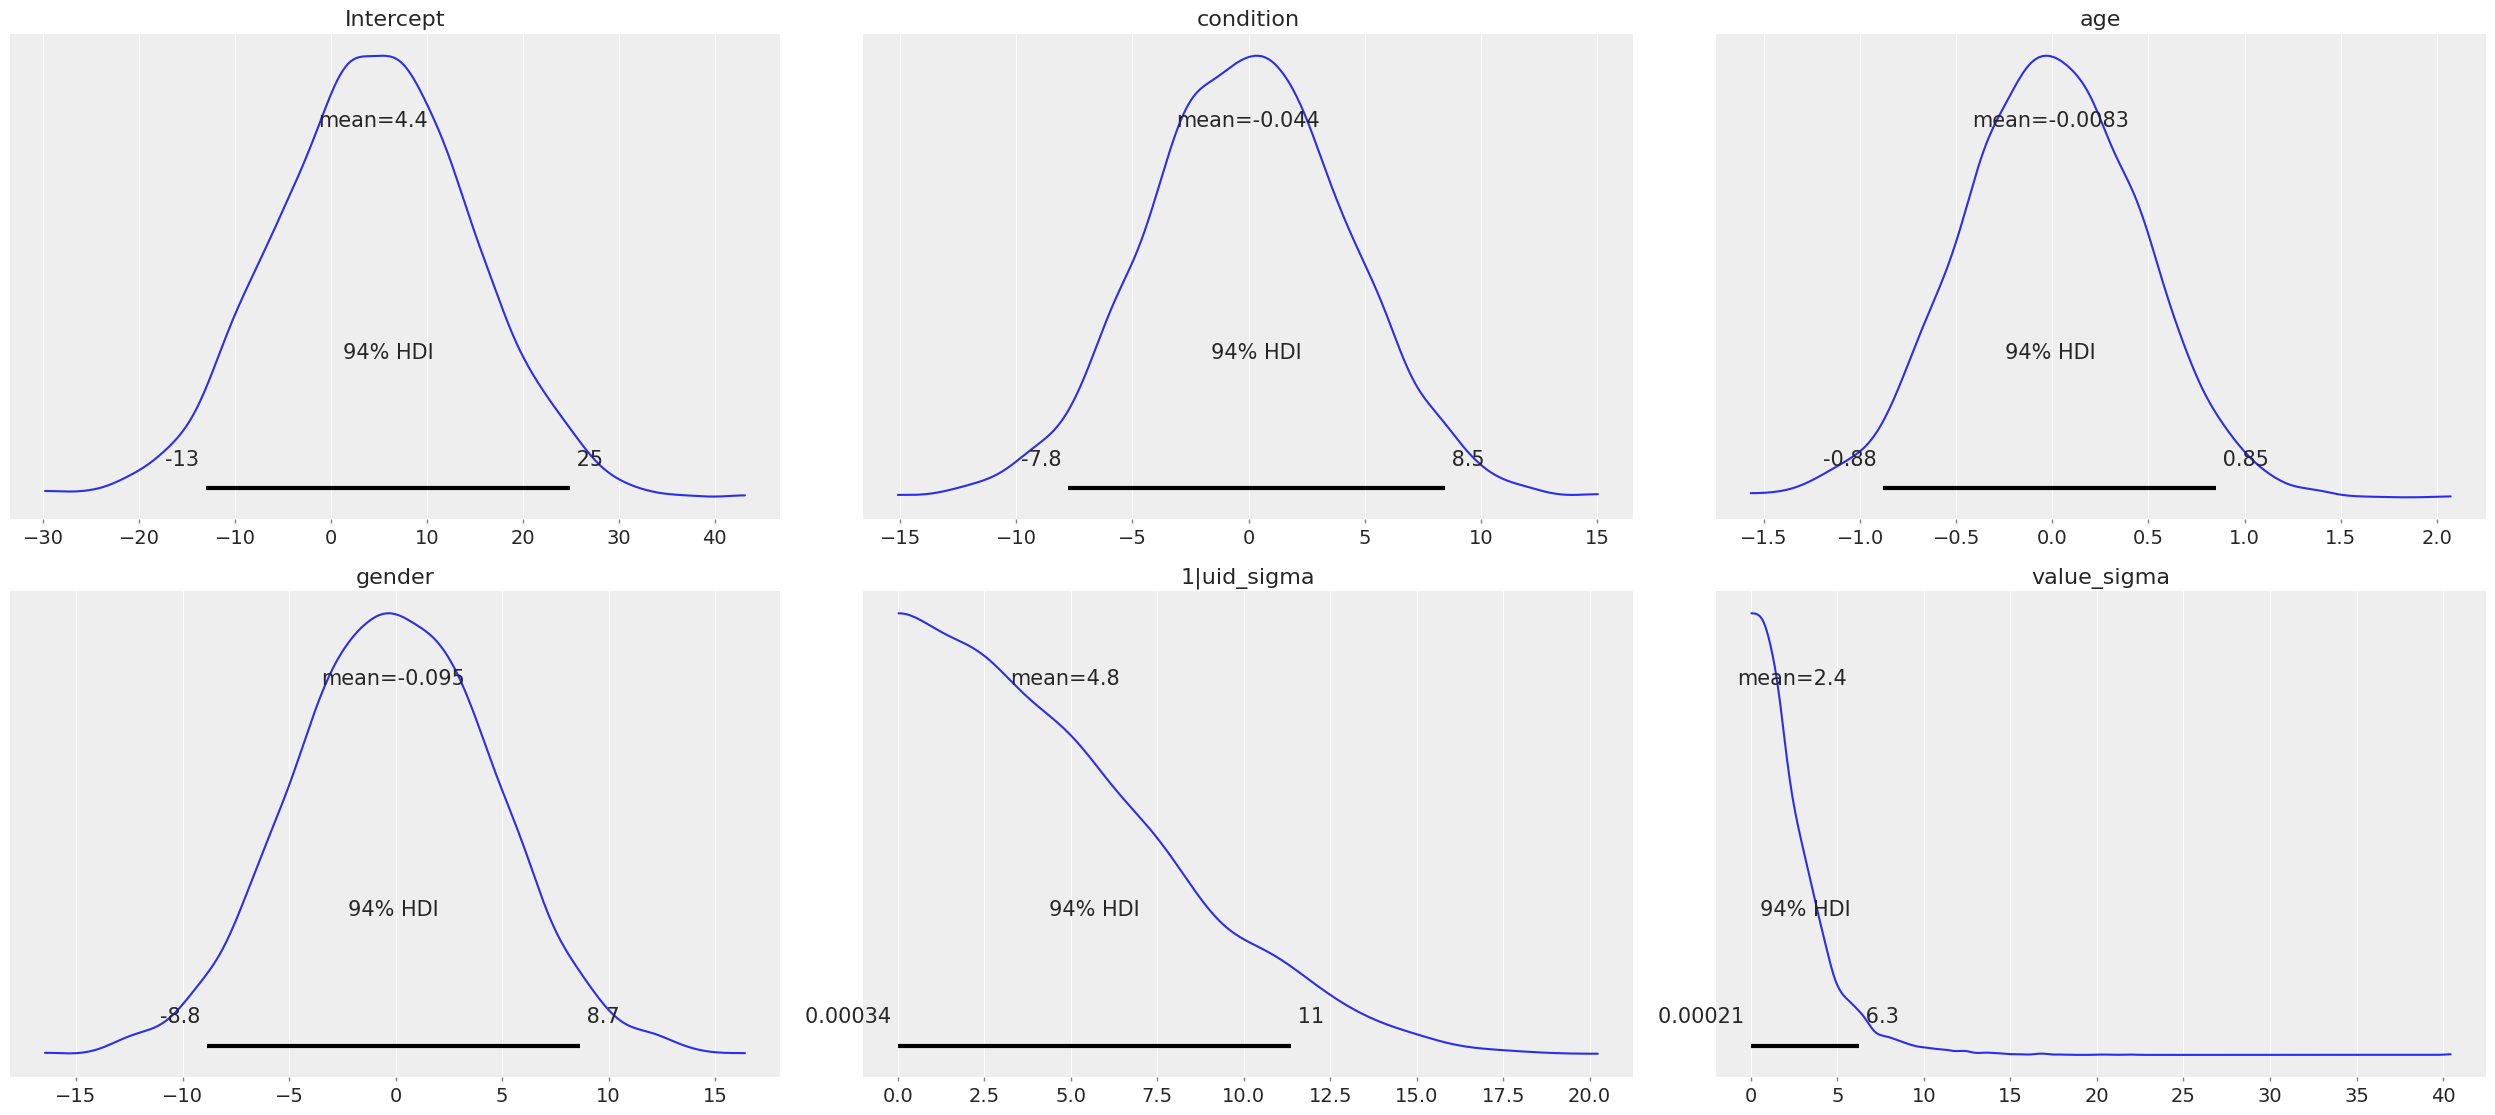

In [11]:
model.plot_priors();

## Specifying priors


Bayesian inference requires one to specify prior probability distributions that represent the analyst's belief (in advance of seeing the data) about the likely values of the model parameters. In practice, analysts often lack sufficient information to formulate well-defined priors, and instead opt to use "weakly informative" priors that mainly serve to keep the model from exploring completely pathological parts of the parameter space (e.g., when defining a prior on the distribution of human heights, a value of 3,000 cms should be assigned a probability of exactly 0).

By default, Bambi will intelligently generate weakly informative priors for all model terms, by loosely scaling them to the observed data (details can be found in [This article](https://arxiv.org/abs/1702.01201). While the default priors will behave well in most typical settings, there are many cases where an analyst will want to specify their own priors--and in general, when informative priors are available, it's a good idea to use them.

By default priors are specified on a (generalized) partial correlation scale that quantifies the expected standardized contribution of each individual term to the outcome variable when controlling for other terms. The default "wide" setting sets the scale of a common effect prior to $\sqrt{1/3} = 0.577$ on the partial correlation scale, which is the standard deviation of a flat prior from -1 to +1. This correlation-level scale value then gets translated to a Normal prior at the slope level, centered on 0 by default, with a correspondingly wide variance. This process results in a weakly informative (rather than non-informative) prior distribution whose width can be tuned in a simple, intuitive way. More detailed information about how the default priors work can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

In cases where we want to keep the default prior distributions, but alter their scale, we can specify either a numeric scale value or pass the name of a predefined constant. For example:

In [12]:
# Add condition to the model as a common effect with a super wide prior
prior = {"condition":"superwide"}
Model("value ~ condition + gender + age + (condition|uid)", data, priors=prior, dropna=True)

Automatically removing 33/6940 rows from the dataset.


Formula: value ~ condition + gender + age + (condition|uid)
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Intercept ~ Normal(mu: 4.5456783, sigma: 10.69319537)
  condition ~ Normal(mu: 0, sigma: 7.17406001)
  gender ~ Normal(mu: 0, sigma: 4.75602005)
  age ~ Normal(mu: 0, sigma: 0.47056711)
  1|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 6.17371922))
  condition|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 7.17406001))
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41856923)

In [13]:
# Add group specific subject intercepts to the model, with a narrow prior on their standard deviation
prior = {"condition|ui":"0.1"}
Model("value ~ condition + gender + age + (condition|uid)", data, priors=prior, dropna=True)

Automatically removing 33/6940 rows from the dataset.


Formula: value ~ condition + gender + age + (condition|uid)
Family name: Gaussian
Link: identity
Observations: 6907
Priors:
  Intercept ~ Normal(mu: 4.5456783, sigma: 10.32623855)
  condition ~ Normal(mu: 0, sigma: 4.35988774)
  gender ~ Normal(mu: 0, sigma: 4.75602005)
  age ~ Normal(mu: 0, sigma: 0.47056711)
  1|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 5.96185661))
  condition|uid ~ Normal(mu: 0, sigma: HalfNormal(sigma: 4.35988774))
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41856923)

Predefined named scales include "superwide" (scale = 0.8), "wide" (0.577; the default), "medium" (0.4), and "narrow" (0.2). The theoretical maximum scale value is 1.0, which specifies a distribution of partial correlations with half of the values at -1 and the other half at +1. Scale values closer to 0 are considered more "informative" and tend to induce more shrinkage in the parameter estimates.

The ability to specify prior scales this way is helpful, but also limited: we will sometimes find ourselves wanting to use something other than a Normal distribution to model our priors. Fortunately, Bambi is built on top of PyMC3, which means that we can seamlessly use any of the over 40 ``Distribution`` classes defined in PyMC3. We can specify such priors in Bambi using the ``Prior`` class, which initializes with a ``name`` argument (which must map on exactly to the name of a valid PyMC3 ``Distribution``) followed by any of the parameters accepted by the corresponding ``distribution``. For example:

In [14]:
from bambi import Prior

# A laplace prior with mean of 0 and scale of 10
my_favorite_prior = Prior('Laplace', mu=0, b=10)

# Set the prior when adding a term to the model; more details on this below.
priors = {'1|uid': my_favorite_prior}
Model("value ~ condition + (1|uid)", data, priors=priors, dropna=True)

Automatically removing 9/6940 rows from the dataset.


Formula: value ~ condition + (1|uid)
Family name: Gaussian
Link: identity
Observations: 6931
Priors:
  Intercept ~ Normal(mu: 4.55157986, sigma: 3.22702781)
  condition ~ Normal(mu: 0, sigma: 4.37400566)
  1|uid ~ Laplace(mu: 0, b: 10)
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41969001)

Priors specified using the ``Prior`` class can be nested to arbitrary depths--meaning, we can set any of a given prior's argument to point to another ``Prior`` instance. This is particularly useful when specifying hierarchical priors on group specific effects, where the individual group specific slopes or intercepts are constrained to share a common source distribution:

In [15]:
subject_sd = Prior('HalfCauchy', beta=5)
subject_prior = Prior('Normal', mu=0, sd=subject_sd)
priors = {'1|uid': subject_prior}
Model("value ~ condition + (1|uid)", data, priors=priors, dropna=True)

Automatically removing 9/6940 rows from the dataset.


Formula: value ~ condition + (1|uid)
Family name: Gaussian
Link: identity
Observations: 6931
Priors:
  Intercept ~ Normal(mu: 4.55157986, sigma: 3.22702781)
  condition ~ Normal(mu: 0, sigma: 4.37400566)
  1|uid ~ Normal(mu: 0, sd: HalfCauchy(beta: 5))
  sigma ~ HalfStudentT(nu: 4, sigma: 2.41969001)

The above prior specification indicates that the individual subject intercepts are to be treated as if they are randomly sampled from the same underlying normal distribution, where the variance of that normal distribution is parameterized by a separate hyperprior (a half-cauchy with beta = 5).

#### Mapping priors onto terms

Once we've defined custom priors for one or more terms, we need to map them onto those terms in our model. Bambi allows us to do this efficiently by passing a dictionary of term -> prior mappings in a ``fit()`` call (and also via a separate ``set_priors()`` method on the ``Model`` class). The keys of the dictionary the names of terms, and the values are the desired priors. There are also ``common`` and ``group_specific`` arguments that make it easy to apply the same priors to all common or group specific effects in the model. Some examples:

In [16]:
data = pd.DataFrame({
    "y" : np.random.normal(size=50),
    "X1" : np.random.normal(size=50),
    "X2" : np.random.normal(size=50),
    "X3" : np.random.normal(size=50),
    "X4" : np.random.normal(size=50)
})

In [17]:
# Example 1: set each prior by name. Note that we can set the same
# prior for multiple terms at once, by passing a tuple in the key.
priors = {
    'X1': 0.3,
    'X2': 'medium',
    ('X3', 'X4'): Prior('ZeroInflatedPoisson', theta=10, psi=0.5)
}
Model("y ~ X1 + X2 + (1|X3) + (1|X4)", data, priors=priors)

Formula: y ~ X1 + X2 + (1|X3) + (1|X4)
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(mu: -0.12153948, sigma: 0.88825888)
  X1 ~ Normal(mu: 0, sigma: 0.30998088)
  X2 ~ Normal(mu: 0, sigma: 0.58628056)
  1|X3 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.5128365))
  1|X4 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.5128365))
  sigma ~ HalfStudentT(nu: 4, sigma: 0.86932731)

In [18]:
# Example 2: specify priors for all common effects and all group specific
# effects, except for X1, which still gets its own custom prior.
priors = {
    'X1': 0.3,
    'common': Prior('Normal', sd=100),
    'group_specific': 'wide'
}
Model("y ~ X1 + X2 + (1|X3) + (1|X4)", data, priors=priors)

Formula: y ~ X1 + X2 + (1|X3) + (1|X4)
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(sd: 100)
  X1 ~ Normal(mu: 0, sigma: 0.30998088)
  X2 ~ Normal(sd: 100)
  1|X3 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.50701283))
  1|X4 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.50701283))
  sigma ~ HalfStudentT(nu: 4, sigma: 0.86932731)

Notice how this interface allows us to specify terms either by name (including passing tuples as keys in cases where we want multiple terms to share the same prior), or by term type (i.e., to set the same prior on all common or group specific effects). If we pass both named priors and common or group specific effects defaults, the former will take precedence over the latter (in the above example, the prior for ``'X1'`` will be ``0.3``).

If we prefer, we can also set priors outside of the model instantiation , using the ``set_priors()`` method:

In [19]:
# Specify model but don't build/sample just yet
model = Model("y ~ X1 + X2 + (1|X3) + (1|X4)", data)

# Specify priors—produces same result as in Example 2 above
model.set_priors(
    {'X1': 0.3},
    common=Prior('Normal', sd=100),
    group_specific='wide'
)

model

Formula: y ~ X1 + X2 + (1|X3) + (1|X4)
Family name: Gaussian
Link: identity
Observations: 50
Priors:
  Intercept ~ Normal(sd: 100)
  X1 ~ Normal(mu: 0, sigma: 0.30998088)
  X2 ~ Normal(sd: 100)
  1|X3 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.50701283))
  1|X4 ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.50701283))
  sigma ~ HalfStudentT(nu: 4, sigma: 0.86932731)

It's important to note that explicitly setting priors by passing in ``Prior`` objects will disable Bambi's default behavior of scaling priors to the data in order to ensure that they remain weakly informative. This means that if you specify your own prior, you have to be sure not only to specify the distribution you want, but also any relevant scale parameters. For example, the 0.5 in ``Prior('Normal', mu=0, sd=0.5)`` will be specified on the scale of the data, not the bounded partial correlation scale that Bambi uses for default priors. This means that if your outcome variable has a mean value of 10,000 and a standard deviation of, say, 1,000, you could potentially have some problems getting the model to produce reasonable estimates, since from the perspective of the data, you're specifying an extremely strong prior.

## Generalized linear mixed models

Bambi supports the construction of mixed models with non-normal response distributions (i.e., generalized linear mixed models, or GLMMs). GLMMs are specified in the same way as LMMs, except that the user must specify the distribution to use for the response, and (optionally) the link function with which to transform the linear model prediction into the desired non-normal response. The easiest way to construct a GLMM is to simple set the ``family`` when creating the model:

In [20]:
data = pd.read_csv("http://www.karlin.mff.cuni.cz/~pesta/prednasky/NMFM404/Data/binary.csv")
model = Model("admit ~ gre + gpa + rank", data, family="bernoulli")
results = model.fit()

Modeling the probability that admit==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rank, gpa, gre, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.8811541866360303, but should be close to 0.8. Try to increase the number of tuning steps.


If no ``link`` argument is explicitly set (see below), the canonical link function (or an otherwise sensible default) will be used. The following table summarizes the currently available families and their associated links:

|Family name    |Response distribution | Default link
|:------------- |:-------------------- |:-------------  |
bernoulli       |    Bernoulli         | logit          |
gamma           |    Gamma             | inverse        |
gaussian        |    Normal            | identity       |
negativebinomial|    NegativeBinomial  | log            |
poisson         |    Poisson           | log            |
wald            |    InverseGaussian   | inverse squared|

## Families

Following the convention used in many R packages, the response distribution to use for a GLMM is specified in a ``Family`` class that indicates how the response variable is distributed, as well as the link function transforming the linear response to a non-linear one. Although the easiest way to specify a family is by name, using one of the options listed in the table above, users can also create and use their own family, providing enormous flexibility. In the following example, we show how the built-in 'bernoulli' family could be constructed on-the-fly:

In [21]:
from bambi import Family
import theano.tensor as tt

# Specify how the Bernoulli p parameter is distributed
prior_p = Prior('Beta', alpha=2, beta=2)

# The response variable distribution
prior = Prior('Bernoulli', p=prior_p)

# Set the link function. Alternatively, we could just set
# the link to 'logit', since it's already built into Bambi.
# Note that we could pass in our own function here; the link
# function doesn't have to be predefined.
link = tt.nnet.sigmoid

# Construct the family
new_fam = Family('bernoulli', prior=prior, link=link, parent='p')

# Now it's business as usual
model = Model("admit ~ gre + gpa + rank", data, family=new_fam)
results = model.fit()

Modeling the probability that admit==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rank, gpa, gre, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


The above example produces results identical to simply setting ``family='bernoulli'``.

One (minor) complication in specifying a custom ``Family`` is that the link function must be able to operate over theano tensors rather than numpy arrays, so you'll probably need to rely on tensor operations provided in ``theano.tensor`` (many of which are also wrapped by PyMC3) when defining a new link.

## Results

When a model is fitted, it returns a ``InferenceData`` object containing data related to the model and the posterior. This object can be passed to many functions in ArviZ to obtain numerical and visuals diagnostics and plot in general.


## Plotting


To visualize a plot of the posterior estimates and sample traces for all parameters, simply pass the ``InferenceData`` object to  the arviz function ``az._plot_trace``:

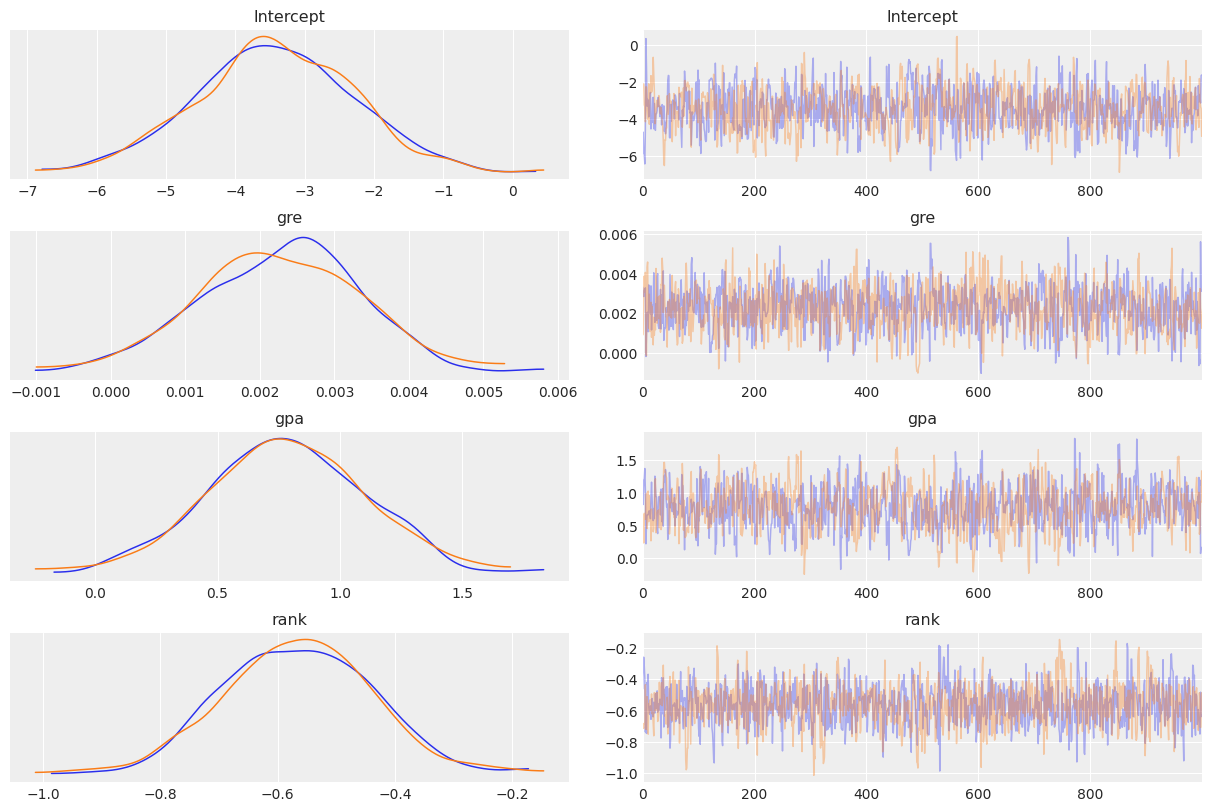

In [22]:
az.plot_trace(results, compact=False);

More details on this plot are available in the [ArviZ documentation](https://arviz-devs.github.io/arviz/_modules/arviz/plots/traceplot.html).

## Summarizing

If you prefer numerical summaries of the posterior estimates, you can use the ``az.summary()`` function from [ArviZ](https://arviz-devs.github.io/arviz/generated/arviz.summary.html#arviz.summary)  which provides a pandas DataFrame with some key summary and diagnostics info on the model parameters, such as the 94% highest posterior density intervals:

In [23]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.433,1.118,-5.600,-1.380,0.040,0.028,793.0,913.0,1.0
gre,0.002,0.001,0.000,0.004,0.000,0.000,993.0,1028.0,1.0
gpa,0.780,0.327,0.176,1.392,0.012,0.009,731.0,838.0,1.0
rank,-0.566,0.131,-0.818,-0.341,0.004,0.003,1193.0,761.0,1.0


If you want to view summaries or plots for specific parameters, you can pass a list of its names:

In [24]:
# show the names of all variables stored in the InferenceData object
list(results.posterior.data_vars)

['Intercept', 'gre', 'gpa', 'rank']

You can find detailed, worked examples of fitting Bambi models and working with the results in the example notebooks [here](bambi/examples.html).

## Accessing back-end objects

Bambi is just a high-level interface to PyMC3; as such. Internally, Bambi stores virtually all objects generated by PyMC3, making it easy for users to retrieve, inspect, and modify those objects. For example, the ``Model`` class created by PyMC3 (as opposed to the Bambi class of the same name) is accessible from `model.backend.model`.